# **Data for modeling**

In [ ]:
pip install "dask[dataframe]" --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 37.6 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc 
import warnings
import dask.dataframe as dd
from matplotlib.pyplot import figure
sns.set()
warnings.filterwarnings("ignore")

In [ ]:
def adjust_datatype(df):
    """
    This function adjust the datatypes of columns based upon their range
    
    Input take DataFrame
    
    example:
    if a column's maximum and minimum values are in range of (-128 to 127) then datatype
    to store that column is changed to int8
    
    Reference:
    https://www.kaggle.com/jeru666/did-you-think-of-these-features
    
    """
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and (np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and (np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and (np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)          
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)
        
        
        
        
        
def restart_kernel():
    """
    Used to get rid of unnessary variable
    
    https://stackoverflow.com/questions/37751120/restart-ipython-kernel-with-a-command-from-a-cell
    """
    from IPython.core.display import HTML
    HTML("<script>Jupyter.notebook.kernel.restart()</script>")
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import gc 
    import warnings
    import dask.dataframe as dd
    from matplotlib.pyplot import figure
    sns.set()
    warnings.filterwarnings("ignore")

In [ ]:
combined = pd.read_csv('/content/drive/MyDrive/KKbox_data/New_preprocessed_Data/combined.csv')

In [ ]:
combined.fillna(0,inplace=True)

In [ ]:
adjust_datatype(combined)

In [ ]:
import re
combined['registration_init_time'] = combined['registration_init_time'].apply(lambda x:int(re.sub('-','',str(x))))

In [ ]:
combined['transaction_date'] = combined['transaction_date'].apply(lambda x:int(re.sub('-','',str(x))))

In [ ]:
combined['membership_expire_date'] = combined['membership_expire_date'].apply(lambda x:int(re.sub('-','',str(x))))

In [ ]:
combined['date'] = combined['date'].apply(lambda x:int(re.sub('-','',str(x))))

In [ ]:
combined  = combined.drop_duplicates('msno', keep='first', inplace=False)

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/KKbox_data/train_v2.csv')

In [ ]:
train_data=pd.merge(train_data,combined,on='msno',how='left')
train_data.fillna(0,inplace=True)

In [ ]:
train_data.shape

(970960, 31)

In [ ]:
train_data  = train_data.drop_duplicates('msno', keep='first', inplace=False)

In [ ]:
train_features = train_data.columns
train_features = list(train_features)
train_features.remove('is_churn')
train_features.remove('msno')
train_data.head()

,msno,is_churn,bd,registered_via,registration_init_time,city_feature,registration_method_f,payment_method_id,payment_plan_days,plan_list_price,...,change_in_plan,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_secs_mean
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,28.0,3.0,20131223.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20170305.0,7.0,0.0,3.0,0.0,71.0,68.0,17599.892578,17599.892578
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,20.0,3.0,20131223.0,1.0,0.0,36.0,30.0,180.0,...,1.0,20170320.0,0.0,1.0,1.0,0.0,0.0,2.0,217.548004,217.548004
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,18.0,3.0,20131227.0,1.0,0.0,17.0,30.0,0.0,...,1.0,20170316.0,10.0,1.0,1.0,1.0,3.0,15.0,1249.300049,1249.300049
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,28.0,7.0,20140109.0,1.0,1.0,41.0,30.0,149.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,35.0,7.0,20140125.0,1.0,1.0,41.0,30.0,99.0,...,1.0,20170304.0,1.0,0.0,1.0,0.0,36.0,36.0,8746.115234,8746.115234


**# Preparing the data for balancing**

In [ ]:
churned_user=train_data[train_data['is_churn']==1]
not_churned_user=train_data[train_data['is_churn']==0]
not_churned_user_sampled=not_churned_user.sample(frac=0.7)
new_sampled_data=not_churned_user_sampled.append(churned_user,ignore_index=True)
new_sampled_data.head()

,msno,is_churn,bd,registered_via,registration_init_time,city_feature,registration_method_f,payment_method_id,payment_plan_days,plan_list_price,...,change_in_plan,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_secs_mean
0,pnXrxGX2UIU9Gje/Hc4KFybz5jyAFbhx7cQMniYsT1w=,0,19.0,3.0,20150721.0,0.0,0.0,39.0,30.0,149.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,VOXaUOmpVzV6MDq8ANvLVnFuEHhA+JLie8VuxJ2pXK0=,0,41.0,9.0,20090322.0,0.0,1.0,39.0,30.0,149.0,...,1.0,20170316.0,7.0,0.0,0.0,0.0,2.0,4.0,527.987000,527.987000
2,vGwutoO/7arh4nVlz2UR7E4++YevdHg8DJWLO5oG+O4=,0,22.0,7.0,20160328.0,0.0,1.0,41.0,30.0,149.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,auYAH0UBiFl+tfMkVOfrjTywDkUgLVsx6rzzX1gzO0I=,0,37.0,9.0,20040702.0,0.0,1.0,33.0,30.0,149.0,...,1.0,20170315.0,2.0,3.0,0.0,1.0,22.0,42.0,5850.359863,5850.359863
4,2eqfnvREFBaMUdmnwcGdqLyNPXwzGp6a3RbvsEoJCwA=,0,28.0,9.0,20040731.0,0.0,1.0,39.0,30.0,149.0,...,1.0,20170331.0,0.0,0.0,0.0,1.0,1.0,2.0,497.769989,497.769989


In [ ]:
new_sampled_data.shape

(705871, 31)

In [ ]:
X_train=new_sampled_data[train_features]
y_train=new_sampled_data['is_churn']

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
sns.set()
from matplotlib.pyplot import figure

**# Balancing data Using SMOTE**

In [ ]:
#using smote to balance the imbalance in the dataset
smote=SMOTE(random_state=110,n_jobs=-1)
X_bal,y_bal=smote.fit_resample(X_train,y_train)

In [ ]:
impute=dict(X_bal.mean())
import pickle
output = open('impute.pkl', 'wb')
pickle.dump(impute, output)
output.close()
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(X_bal)
X_bal=sc.transform(X_bal)
X_bal.shape

(1237082, 29)

In [ ]:
with open("sc.pkl", 'wb') as output:
    pickle.dump(sc, output, pickle.HIGHEST_PROTOCOL)
print(X_bal.shape,y_bal.shape)

(1237082, 29) (1237082,)


**# loading test data**

In [ ]:
test_data=pd.read_csv('/content/drive/MyDrive/KKbox_data/sample_submission_v2.csv')
test_data=pd.merge(test_data,combined,on='msno',how='left')

In [ ]:
test_data.fillna(impute,inplace=True)

In [ ]:
test_data  = test_data.drop_duplicates('msno', keep='first', inplace=False)

In [ ]:
X_test=test_data[train_features]
X_test=sc.transform(X_test)

In [ ]:
print(X_bal.shape,X_test.shape)

(1237082, 29) (907471, 29)


**# Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_cv,y_train,y_cv = train_test_split(X_bal,y_bal,test_size=0.3,random_state=110,stratify=y_bal)

In [ ]:
print(X_train.shape,X_cv.shape)

(865957, 29) (371125, 29)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
def result(y_pred,y_pred_proba,y_true,confusion=0,silent=0):
    """
    Function require 3 inputs
    predicted value
    predicted probabilities
    true labels
    final 1 or 0 
    if 1 confusion matrix will be printed
    """
    loss=log_loss(y_true,y_pred_proba)
    if silent==0:
        print("log loss is ",loss)
        print('F1 score is',f1_score(y_true,y_pred))
    if confusion==1:
        cf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(cf_matrix, annot=True,fmt='d')
        plt.show()
    return loss

def lowest(hyperparameter,loss_all):
    """
    this function return the
    best hyperparameter and lowest loss associated with it
    """
    lowest_loss_index=np.argsort(loss_all)[0]
    lowest_loss=loss_all[lowest_loss_index]
    hyperparameter=hyperparameter[lowest_loss_index]
    print( 'The best hyperparameter is ',hyperparameter,'and the lowest loss associaed with it ',lowest_loss)
    return hyperparameter
def plot_result(hyperparameter,loss_all):
    figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    sns.scatterplot(x=hyperparameter,y=loss_all)
    plt.plot()

# **Logistic regression with l1**

Model is training
Done
log loss is  0.33512849077200774
F1 score is 0.8481155431335966
Model is training
Done
log loss is  0.32892273221928137
F1 score is 0.8540978981520666
Model is training
Done
log loss is  0.3277699514067516
F1 score is 0.8545145668708543
Model is training
Done
log loss is  0.32696738992966945
F1 score is 0.8546356729020707
Model is training
Done
log loss is  0.3268674454617268
F1 score is 0.8546841081446817
Model is training
Done
log loss is  0.32679698257722506
F1 score is 0.8546639884413434
The best hyperparameter is  100 and the lowest loss associaed with it  0.32679698257722506
----------------------------------------------------------------------------------------------
Training model with best hyperparameter
Model is training
Done
log loss is  0.3262687108457936
F1 score is 0.8542288149251959


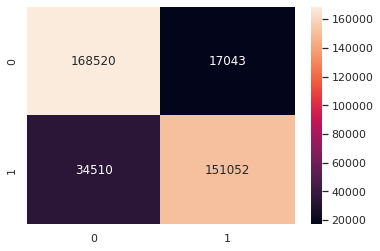

----------------------------------------------------------------------------------------------


In [ ]:
sample_points_train=int(0.4*X_train.shape[0])
sample_points_cv=int(0.4*X_cv.shape[0])

from sklearn.linear_model import LogisticRegression
feature_importance_lr=[]
feature_importance_values_lr=[]
reg=[]
loss_all=[]


#hyperparameter tuning

for i in [10**i for i in range(-3,3)]:
    model=LogisticRegression(C=i,n_jobs=-1,random_state=110,penalty='l1',solver='liblinear')
    print("Model is training")
    model.fit(X_train[:sample_points_train],y_train[:sample_points_train])
    print("Done")
    y_pred_proba=model.predict_proba(X_cv[:sample_points_cv])
    y_pred=model.predict(X_cv[:sample_points_cv])
    loss=result(y_pred,y_pred_proba,y_cv[:sample_points_cv])
    reg.append(i)
    loss_all.append(loss)
hyperparameter=lowest(reg,loss_all)


# training model with best hyperparameter

print("----------------------------------------------------------------------------------------------")
print("Training model with best hyperparameter")
model=LogisticRegression(C=hyperparameter,n_jobs=-1,random_state=110,penalty='l1',solver='liblinear')
print("Model is training")
model.fit(X_train,y_train)
print("Done")
y_pred_proba=model.predict_proba(X_cv)
y_pred=model.predict(X_cv)
loss=result(y_pred,y_pred_proba,y_cv,confusion=1)
print("----------------------------------------------------------------------------------------------")

# **Logistic regression with L2**

Model is training
Done
log loss is  0.33379494908522156
F1 score is 0.8489587760305992
Model is training
Done
log loss is  0.3308268206320705
F1 score is 0.8527435926385909
Model is training
Done
log loss is  0.330222027630256
F1 score is 0.8536277558041977
Model is training
Done
log loss is  0.33009616636851297
F1 score is 0.8543846668780608
Model is training
Done
log loss is  0.3298305199481093
F1 score is 0.8537001522928536
Model is training
Done
log loss is  0.32988761596392524
F1 score is 0.8532050558627694
The best hyperparameter is  10 and the lowest loss associaed with it  0.3298305199481093
---------------------------------------------------------------------------
Training model with best hyperparameter
Model is training
Done
log loss is  0.3268573849501192
F1 score is 0.8542112352428493


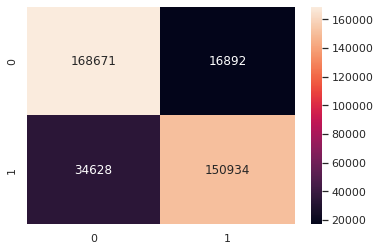

In [ ]:
sample_points_train=int(0.4*X_train.shape[0])
sample_points_cv=int(0.4*X_cv.shape[0])

from sklearn.linear_model import LogisticRegression
feature_importance_lr=[]
feature_importance_values_lr=[]
reg=[]
loss_all=[]


#hyperparameter tuning

for i in [10**i for i in range(-3,3)]:
    model=LogisticRegression(C=i,n_jobs=-1,random_state=110)
    print("Model is training")
    model.fit(X_train[:sample_points_train],y_train[:sample_points_train])
    print("Done")
    y_pred_proba=model.predict_proba(X_cv[:sample_points_cv])
    y_pred=model.predict(X_cv[:sample_points_cv])
    loss=result(y_pred,y_pred_proba,y_cv[:sample_points_cv])
    reg.append(i)
    loss_all.append(loss)
hyperparameter=lowest(reg,loss_all)


# training model with best hyperparameter

print("---------------------------------------------------------------------------")
print("Training model with best hyperparameter")
model=LogisticRegression(C=hyperparameter,n_jobs=-1,random_state=110)
print("Model is training")
model.fit(X_train,y_train)
print("Done")
y_pred_proba=model.predict_proba(X_cv)
y_pred=model.predict(X_cv)
loss=result(y_pred,y_pred_proba,y_cv,confusion=1)



# **Random Forest classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
feature_importance_rf=[]
feature_importance_values_rf=[]
parameter=[]
loss_all=[]

#hyperparameter tuning
for i in [100,200,500]:
    for j in [2,5,10,50]:
        model=RandomForestClassifier(n_estimators=i,random_state=110,n_jobs=-1,min_samples_split=j)
        print("Model is training")
        model.fit(X_train[:sample_points_train],y_train[:sample_points_train])
        print("Done")
        y_pred_proba=model.predict_proba(X_cv[:sample_points_cv])
        y_pred=model.predict(X_cv[:sample_points_cv])
        loss=result(y_pred,y_pred_proba,y_cv[:sample_points_cv])
        parameter.append((i,j))
        loss_all.append(loss)

Model is training
Done
log loss is  0.11030388046482834
F1 score is 0.948684228740708
Model is training
Done
log loss is  0.10964490500741578
F1 score is 0.9485383678440925
Model is training
Done
log loss is  0.1109882542992065
F1 score is 0.9482426876704365
Model is training
Done
log loss is  0.11393127906744042
F1 score is 0.9471922081874905
Model is training
Done
log loss is  0.10886782375100205
F1 score is 0.9487539706157138
Model is training
Done
log loss is  0.10919089986919596
F1 score is 0.9485462018572081
Model is training
Done
log loss is  0.11035429460351263
F1 score is 0.9482615435721404
Model is training
Done
log loss is  0.1135893823931315
F1 score is 0.9471557652658816
Model is training
Done
log loss is  0.10848537949769098
F1 score is 0.9486409433126661
Model is training
Done
log loss is  0.10892537166689331
F1 score is 0.9485783089176604
Model is training
Done
log loss is  0.10979475257899375
F1 score is 0.9482622596852551
Model is training
Done
log loss is  0.11354519

The best hyperparameter is  (500, 2) and the lowest loss associaed with it  0.10848537949769098
---------------------------------------------------------------------------------------------
Training model with best hyperparameter
Model is training
Done
log loss is  0.10422030414729824
F1 score is 0.950132603896194


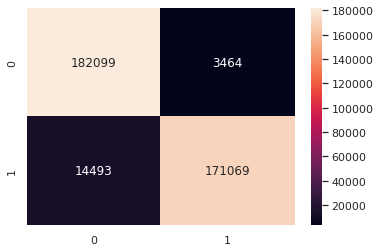

In [ ]:
hyperparameter=lowest(parameter,loss_all)


# training model with best hyperparameter

print("---------------------------------------------------------------------------------------------")
print("Training model with best hyperparameter")
model=RandomForestClassifier(n_estimators=hyperparameter[0],n_jobs=-1,random_state=110,min_samples_split=hyperparameter[1])
print("Model is training")
model.fit(X_train,y_train)
print("Done")
y_pred_proba=model.predict_proba(X_cv)
y_pred=model.predict(X_cv)
loss=result(y_pred,y_pred_proba,y_cv,confusion=1)



# **XGB Classifier**

In [ ]:
from xgboost import XGBClassifier
hyp=[]
feature_importance_xgb=[]
feature_importance_values_xgb=[]
loss_all=[]


#hyperparameter tuning

for i in [100,200,500,1000]:
    for j in [0.5,0.6,0.8]:
        model=XGBClassifier(n_estimators=i,verbosity=1,n_jobs=-1,scale_pos_weight=j,random_state=110)
        print("Model is training")
        model.fit(X_train[:sample_points_train],y_train[:sample_points_train])
        print("Done")
        y_pred_proba=model.predict_proba(X_cv[:sample_points_cv])
        y_pred=model.predict(X_cv[:sample_points_cv])
        loss=result(y_pred,y_pred_proba,y_cv[:sample_points_cv],silent=1)
        hyp.append((i,j))
        loss_all.append(loss)

Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done
Model is training
Done


The best hyperparameter is  (1000, 0.8) and the lowest loss associaed with it  0.11662084976149209
----------------------------------------------------------------------------------------------
Training model with best hyperparameter
Model is training
Done
log loss is  0.11284224573004356
F1 score is 0.944588247107521


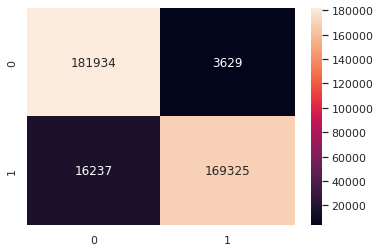

-----------------------------------------------------------------------------------------------


In [ ]:
# training model with best hyperparameter

hyperparameter=lowest(hyp,loss_all)
print("----------------------------------------------------------------------------------------------")
print("Training model with best hyperparameter")
model=XGBClassifier(n_estimators=hyperparameter[0],n_jobs=-1,random_state=110,scale_pos_weight=hyperparameter[1],verbosity=1)
print("Model is training")
model.fit(X_train,y_train)
print("Done")
y_pred_proba=model.predict_proba(X_cv)
y_pred=model.predict(X_cv)
loss=result(y_pred,y_pred_proba,y_cv,confusion=1)
print("-----------------------------------------------------------------------------------------------")



In the upcoming phase , we shall proceed with advanced modeling methods and adding more imporatnt features.
